# Decoding cell sub-population based on kinetic parameters of pancreatic endocrinogenesis data

This tutorial shows how to derive cell fates at the embedding space. Moreover, our advantage of decoding cell sub-population based on kinetic parameters will be shown.

In this analysis of the pancreatic endocrinogenesis data, we follow the gene and cell filtering methods of [Bergen et.al](https://www.nature.com/articles/s41587-020-0591-3). 3,696 cells with 2,000 genes are selected. 

## Import Packages

To run the notebook locally, [Getting Started](link) could be referred to install the environment and dependencies.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import random
import sys
import pandas as pd
import math
import matplotlib.pyplot as plt

# import from absolute directory
#srcdir = '/Users/pengzhizhang/cellDancer/src'
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'
# srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
# srcdir = '/Users/chen.weiqing/Documents/GitHub/cellDancer/src'
sys.path.append(srcdir)
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

## Load the velocity estimation result of all 2,000 genes in pancreatic endocrinogenesis data

To display the prediction in the embedding space and to build the Uniform Manifold Approximation and Projection (UMAP) of kinetic parameters by using all genes, all the 2,000 genes have already been predicted and could be downloaded from DentateGyrus_cellDancer_estimation.csv. The result was predicted from [PancreaticEndocrinogenesis.csv](link) with ```cd.velocity_estimation.velocity(cell_type_u_s, permutation_ratio=0.5, n_jobs=8)```. For the detail of pre-processing, [Data Preprocessing](link) could be referred.

The prediction result is online at [PancreaticEndocrinogenesis_cellDancer_estimation.csv](xxx). It could be loaded with ```pd.read_csv('your_path/PancreaticEndocrinogenesis_cellDancer_estimation.csv')```. 

In [2]:
#detail_result_path = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/pancreas/velocity_result/velocity_result_all_genes_with_bin/2000_smooth/combined_detail/combined_detail.csv'
#cellDancer_df_path = '/Users/wanglab/Documents/ShengyuLi/Velocity/data/pancreas/velocity_result/2000_smooth/velocity_result_all_genes_with_bin/combined_detail/combined_detail.csv'
cellDancer_df_path = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/pancreas/velocity_result/fin_parameter_0529/cell_dancer_velocity_2022-05-28 19-03-50/celldancer_estimation.csv'
#detail_result_path = '/Users/chen.weiqing/code/celldancer/pancreas/combined_detail.csv'

cellDancer_df=pd.read_csv(cellDancer_df_path)
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Scaper,0.489151,0.211323,0.486841,0.185478,0.334391,0.629880,0.647696,0.043435,AAACCTGAGAGGGATA,Pre-endocrine,6.143066,-0.063644
1,1,Scaper,0.278262,0.125742,0.293904,0.107517,0.224909,0.626946,0.648537,0.043435,AAACCTGAGCCTTGAT,Ductal,-9.906417,0.197778
2,2,Scaper,0.374380,0.298116,0.348888,0.197525,0.213979,0.648890,0.665279,0.043435,AAACCTGAGGCAATTA,Alpha,7.559791,0.583762
3,3,Scaper,0.320497,0.198031,0.318165,0.146120,0.219611,0.636208,0.655523,0.043435,AAACCTGCATCATCCC,Ductal,-11.283765,4.218998
4,4,Scaper,0.239145,0.141970,0.251417,0.106599,0.192050,0.631560,0.652837,0.043435,AAACCTGGTAAGTGGC,Ngn3 high EP,1.721565,-4.753407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391995,3691,Tmem63a,0.000000,0.136270,0.000447,0.125414,0.005472,0.110095,0.067564,0.045492,TTTGTCAAGTGACATA,Pre-endocrine,4.768472,-1.388353
7391996,3692,Tmem63a,0.028708,0.000000,0.021286,0.022931,0.017270,0.100517,0.072741,0.045492,TTTGTCAAGTGTGGCA,Ngn3 high EP,-1.873335,-4.182650
7391997,3693,Tmem63a,0.000000,0.312690,0.000200,0.288797,0.002445,0.116196,0.064809,0.045492,TTTGTCAGTTGTTTGG,Ductal,-9.882250,-0.105594
7391998,3694,Tmem63a,0.028052,0.154164,0.019519,0.165354,0.008143,0.107124,0.069812,0.045492,TTTGTCATCGAATGCT,Alpha,6.612424,4.531895


## Compute Cell Velocity

The prediction in the embedding space could be calculated with ```celldancer.compute_cell_velocity.compute()```. If not specified, all genes in cellDancer_df will be used to calculate the prediction in the embedding space. Following the method of [velocyto](link) and [scVelo](link), we project the velocity vectors of the cells into the low-dimensional embedding space.

After the calculation, the predicted direction in the embedding space, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```cdplt.cell.scatter_cell()``` could be used to display the predicted direction in embedding space.

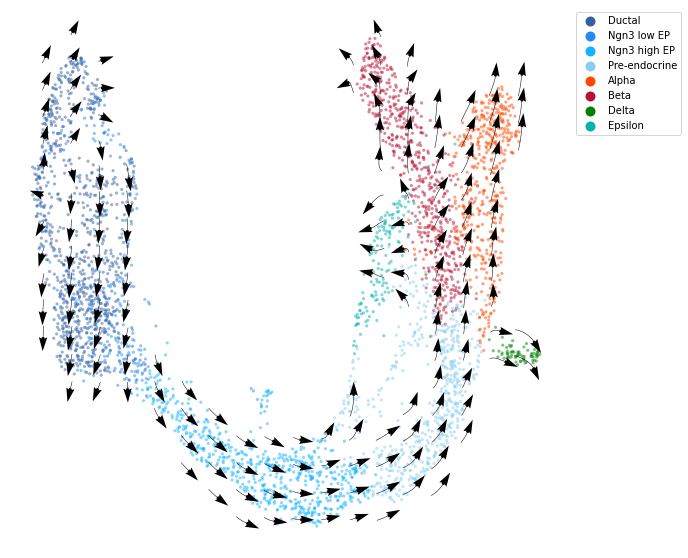

In [3]:
%autoreload 2

# Compute cell velocity
cellDancer_df=cd.compute_cell_velocity.compute(cellDancer_df=cellDancer_df, projection_neighbor_size=100)

# Plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
im = cdplt.cell.scatter_cell(ax, cellDancer_df, colors=colormap.colormap_pancreas, alpha=0.5, s=10, velocity=True, legend='on', min_mass=5, arrow_grid=(20,20))
ax.axis('off')
plt.show()

## Kinetic UMAP based on alpha, beta, and gamma

After obtaining the prediction result, ```celldancer.embedding_kinetic_para.embedding()``` could build the UMAP based on the predicted alpha, beta, gamma, or all of the three.

In [4]:
%autoreload 2

cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'alpha')
cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'beta')
cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'gamma')
cellDancer_df=cd.embedding_kinetic_para.embedding(cellDancer_df,'alpha_beta_gamma')

The UMAP could be visualized with ```cd.cdplt.cell.plot_kinetic_para``` depending on the selection of kinetic parameter(s). This result shows that our kinetic parameters could reflect cell sub-population. The spliced reads of one gene could be visualized when specifying the particular gene in ```cd.cdplt.cell.plot_kinetic_para()```.

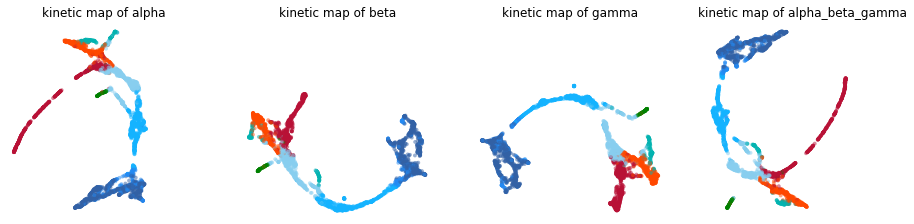

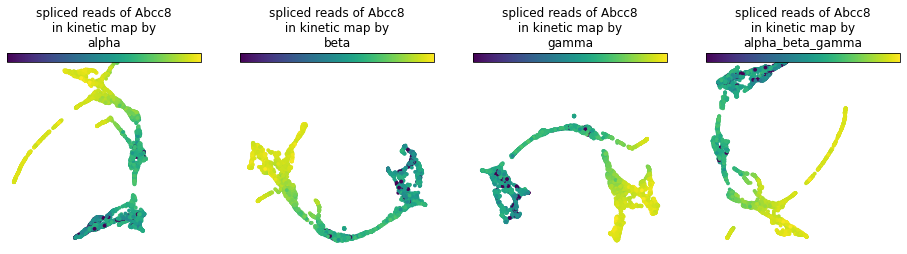

In [5]:
%autoreload 2

fig, ax = plt.subplots(ncols=4, figsize=(16,8))
cd.cdplt.cell.plot_kinetic_para(ax[0], 'alpha_beta_gamma', cellDancer_df, color_map=colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[1], 'alpha', cellDancer_df, color_map=colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[2], 'beta', cellDancer_df, color_map=colormap.colormap_pancreas)
cd.cdplt.cell.plot_kinetic_para(ax[3], 'gamma', cellDancer_df, color_map=colormap.colormap_pancreas)

## Estimate Pseudotime

Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8330/8330 [00:03<00:00, 2293.03it/s]


use path_similarity:  0.4
There are 3 clusters.
[0 1 2]


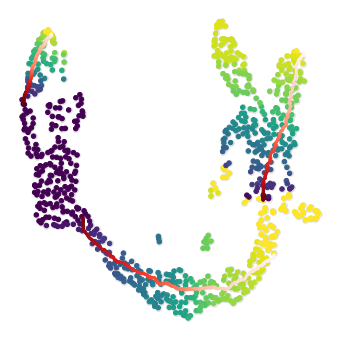




Cluster  0
Total cells in the cluster:  485
MAX allowed zero time cells:  24
MAX allowed terminal cells:  24
171  zero cells left.
Sample trajs for zero-time cells in cluster  0   ...
Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Cluster  0
Total cells in the cluster:  171
MAX allowed zero time cells:  24
MAX allowed terminal cells:  24
Only  2  zero cells left. 
[93, 169]
Only  2  terminal cells left.
[37, 711]
64  terminal cells left.
Sample trajs for terminal cells in cluster  0  ...
Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Cluster  0
Total cells in the cluster:  64
MAX allowed zero time cells:  24
MAX allowed terminal cells:  24
Only  10  zero cells left. 
[46, 318, 380, 547, 548, 683, 691, 722, 763, 802]
Only  2  terminal cells left.
[364, 789]
number of paths:  3 3

Display reference paths for cluster 0


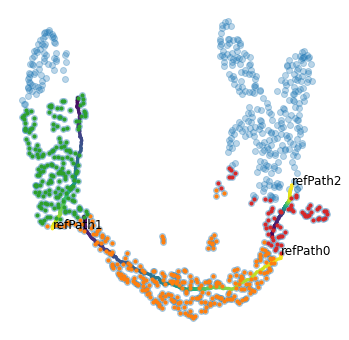


intercluster cell time adjustment
number of cells:  485
Cutoff is  0.04312519063311792
Number of nodes:  3
clusterIDs:  [0, 1, 2]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (77, 17)
pair_cellIDs:  (797, 313)
pair_cellIDs:  (435, 711)
pair_cellIDs:  (731, 558)
pair_cellIDs:  (642, 252)
pair_cellIDs:  (270, 686)
pair_cellIDs:  (281, 678)
pair_cellIDs:  (771, 589)
pair_cellIDs:  (754, 666)
pair_cellIDs:  (793, 803)
pair_cellIDs:  (365, 21)

Peak mode:  most_frequent_shift


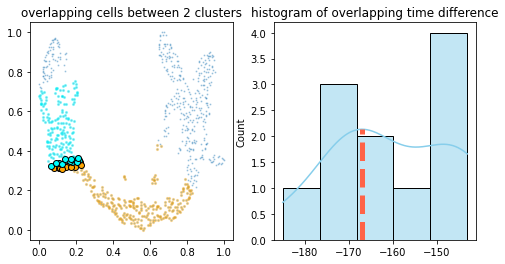

Time shift is:  -167
The overlapping cells are: 
cell  731  from cluster  0  and  558  from cluster  1

Consolidating time between clusters  0  and  2 ...
pair_cellIDs:  (473, 763)
pair_cellIDs:  (237, 569)
pair_cellIDs:  (667, 318)
pair_cellIDs:  (480, 802)
pair_cellIDs:  (820, 683)
pair_cellIDs:  (600, 547)
pair_cellIDs:  (622, 263)

Peak mode:  most_frequent_shift


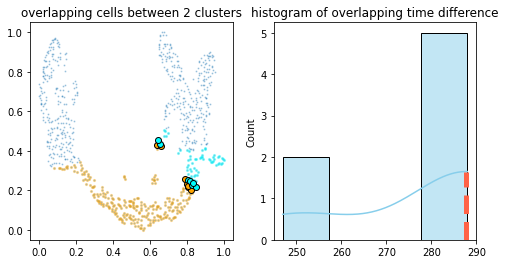

Time shift is:  288
The overlapping cells are: 
cell  473  from cluster  0  and  763  from cluster  2

Consolidating time between clusters  1  and  2 ...
No close cells between clusters	 (1, 2)


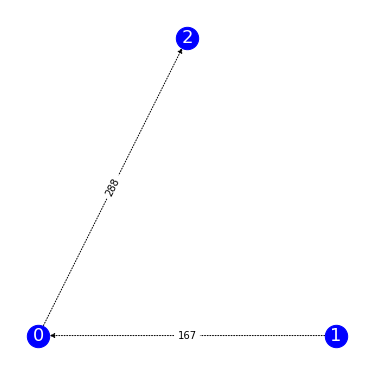

Connected components:  {0, 1, 2}
All nodes adjustment:  {0: 0, 1: -167, 2: 288}



Cluster  1
Total cells in the cluster:  277
MAX allowed zero time cells:  13
MAX allowed terminal cells:  13
Only  1  zero cells left. 
[816]
Only  1  terminal cells left.
[774]
number of paths:  1 1

Display reference paths for cluster 1


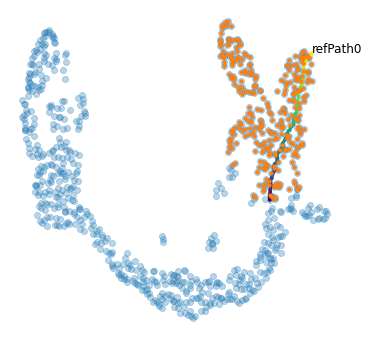




Cluster  2
Total cells in the cluster:  71
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  2  zero cells left. 
[25, 730]
Only  4  terminal cells left.
[226, 268, 386, 486]
number of paths:  1 1

Display reference paths for cluster 2


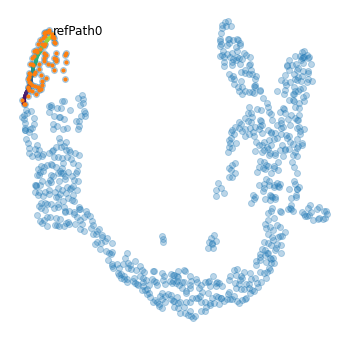




All intra cluster cell time has been resolved.




intercluster cell time adjustment
number of cells:  833
Cutoff is  0.06480627284026959
Number of nodes:  3
clusterIDs:  [0, 1, 2]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (340, 757)
pair_cellIDs:  (183, 533)
pair_cellIDs:  (364, 116)
pair_cellIDs:  (492, 167)
pair_cellIDs:  (720, 707)
pair_cellIDs:  (466, 388)
pair_cellIDs:  (789, 549)
pair_cellIDs:  (298, 703)
pair_cellIDs:  (677, 136)
pair_cellIDs:  (690, 816)
pair_cellIDs:  (652, 821)
pair_cellIDs:  (775, 34)

Peak mode:  most_frequent_shift


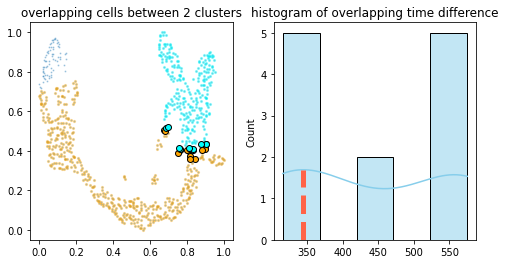

Time shift is:  338
The overlapping cells are: 
cell  652  from cluster  0  and  821  from cluster  1

Consolidating time between clusters  0  and  2 ...
pair_cellIDs:  (171, 730)
pair_cellIDs:  (418, 25)
pair_cellIDs:  (618, 367)
pair_cellIDs:  (619, 709)
pair_cellIDs:  (742, 770)

Peak mode:  most_frequent_shift


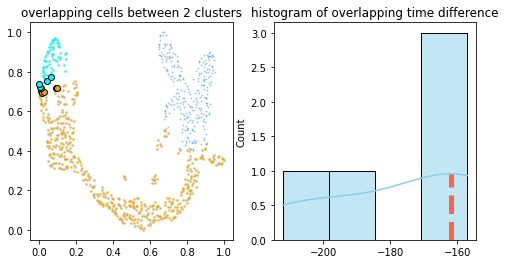

Time shift is:  -164
The overlapping cells are: 
cell  618  from cluster  0  and  367  from cluster  2

Consolidating time between clusters  1  and  2 ...
No close cells between clusters	 (1, 2)


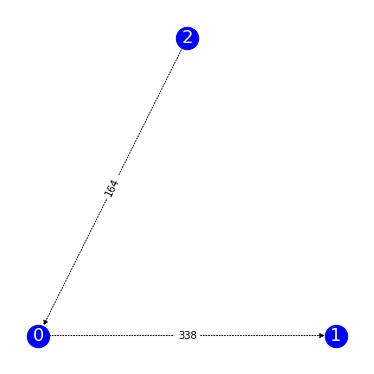

Connected components:  {0, 1, 2}
All nodes adjustment:  {0: 0, 1: 338, 2: -164}


All inter cluster cell time has been resolved.



There are 3696 cells.


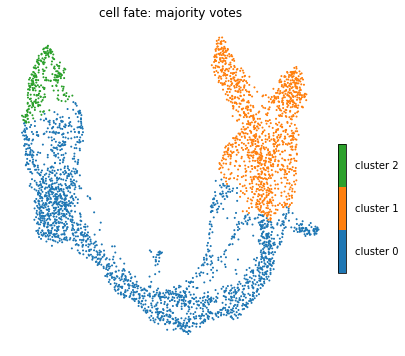

--- 24.494252920150757 seconds ---


In [7]:
%autoreload 2

cell_time = dict()
dt = 0.01
#t_total = {dt:int(10/dt)} 
t_total = {0.01: 10000}
n_repeats = 10

grid = (20,20)
speed_up=(100,100)
cellDancer_df = cd.pseudo_time.pseudo_time(
    cellDancer_df=cellDancer_df, 
    grid=grid, 
    dt=dt, 
    t_total=t_total[dt], 
    n_repeats=n_repeats, 
    speed_up=speed_up,
    n_paths = 3,
    psrng_seeds_diffusion=[i for i in range(n_repeats)],
    activate_umap_paths_divider=False,
    n_jobs=12)

## Plot Pseudotime

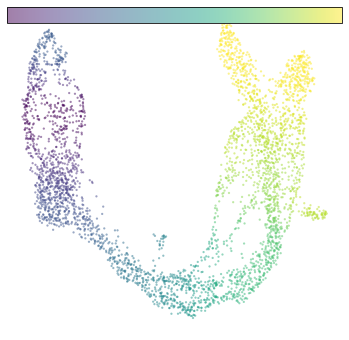

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
clusters = cellDancer_df['clusters'].drop_duplicates().to_list()
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, 
             velocity=False)
ax.axis('off')
plt.show()

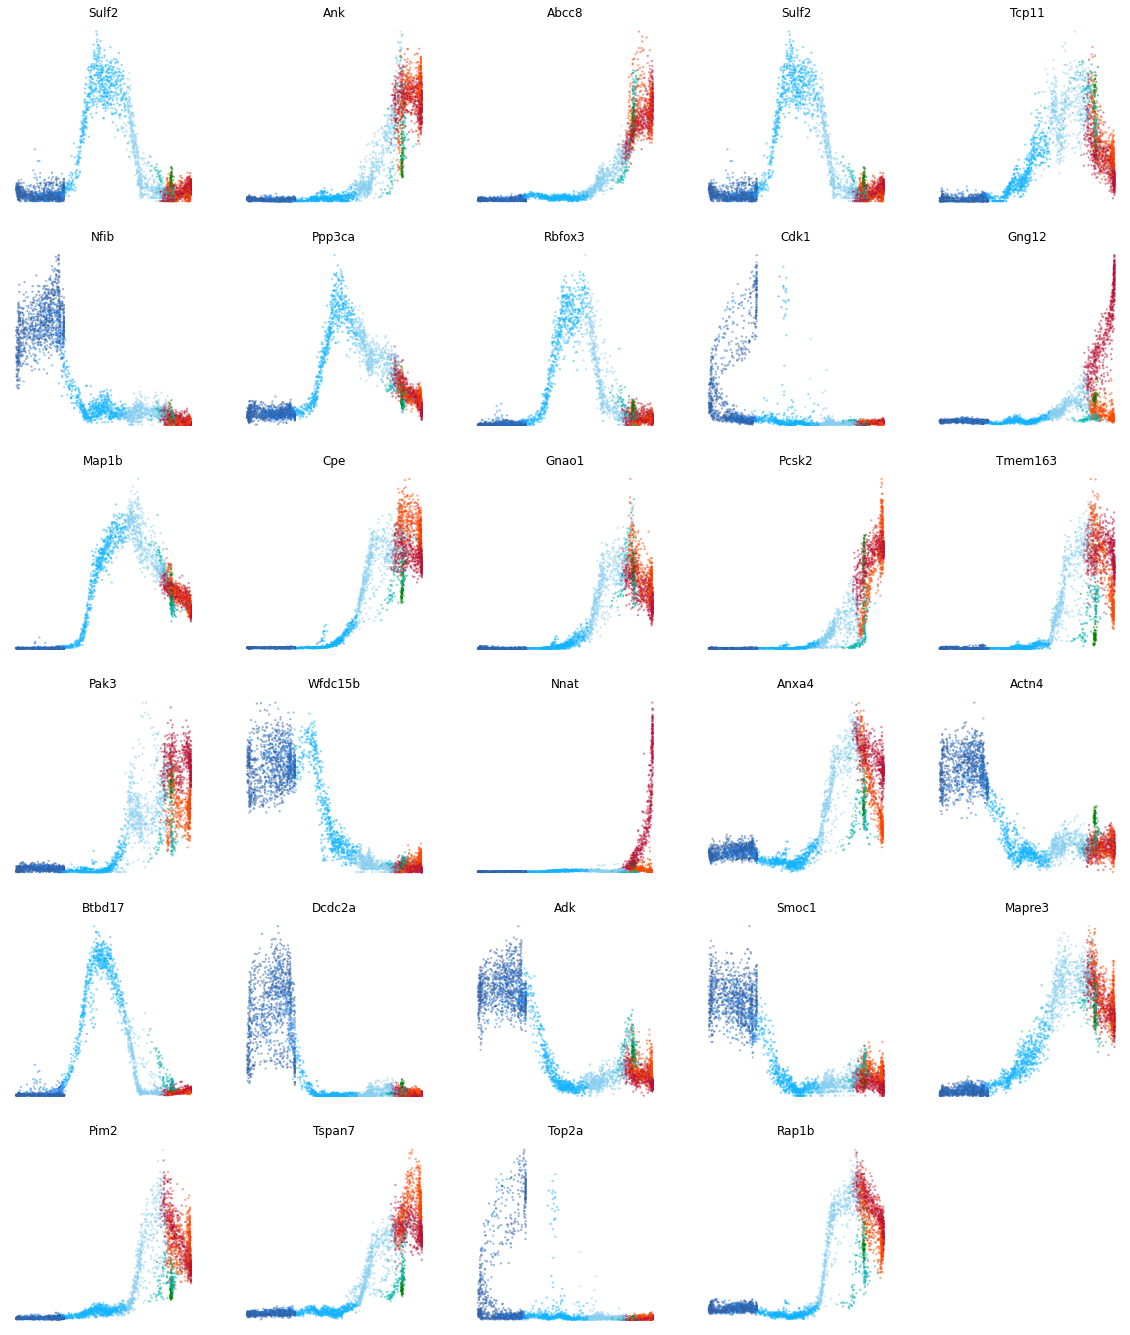

In [16]:
gene_list=['Sulf2',"Ank","Abcc8","Sulf2","Tcp11","Nfib","Ppp3ca",
        "Rbfox3","Cdk1","Gng12","Map1b","Cpe",
        "Gnao1","Pcsk2","Tmem163","Pak3","Wfdc15b",
        "Nnat","Anxa4","Actn4","Btbd17","Dcdc2a",
        "Adk","Smoc1","Mapre3","Pim2","Tspan7",
        "Top2a","Rap1b"]

ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_pancreas,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')